In [4]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
from glob import glob
from datetime import datetime, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm.notebook import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from scipy import stats
from scipy.special import inv_boxcox, logit
from scipy.special import expit as sigmoid

import warnings

from data.data_path import data_path

In [6]:
def load_data(u):

    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]

    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format="ISO8601")
    df.dt = df.dt.dt.tz_convert("Europe/London")

    all_pos = df.step_midnight.values

    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestamp = (
        np.asarray(
            [
                (dt - datetime.combine(dt, time.min, dt.tz)).total_seconds()
                for dt in df.dt
            ]
        )
        / 86400
    )  # in fraction of day (between 0 and 1)

    # List of step events for each day, the event itself being the timestamp of the step
    step_events = [[] for _ in range(uniq_days.size)]

    for idx_day, day in enumerate(uniq_days):
        is_day = days == day
        obs_timestamp, obs_pos = all_timestamp[is_day], all_pos[is_day]

        # Sort the data by timestamp
        idx = np.argsort(obs_timestamp)
        obs_timestamp, obs_pos = obs_timestamp[idx], obs_pos[idx]

        # Compute the number of steps between each observed timestamp
        diff_obs_pos = np.diff(obs_pos)

        for ts, dif in zip(obs_timestamp, diff_obs_pos):
            # TODO: In the future, we probably want to spread that
            #  over a period assuming something like 6000 steps per hour
            step_events[idx_day] += [ts for _ in range(dif)]

    return step_events

In [7]:
user = "11AV"  # Select the user to use
bkp_folder = f"../../bkp/compute_transition_matrices/{user}*"

# Load data
step_events = load_data(user)
print("n_days raw", len(step_events))
step_events = [i for i in step_events if len(i)]
n_days = len(step_events)
print("n_days after filtering empty days", len(step_events))

n_days raw 18
n_days after filtering empty days 17


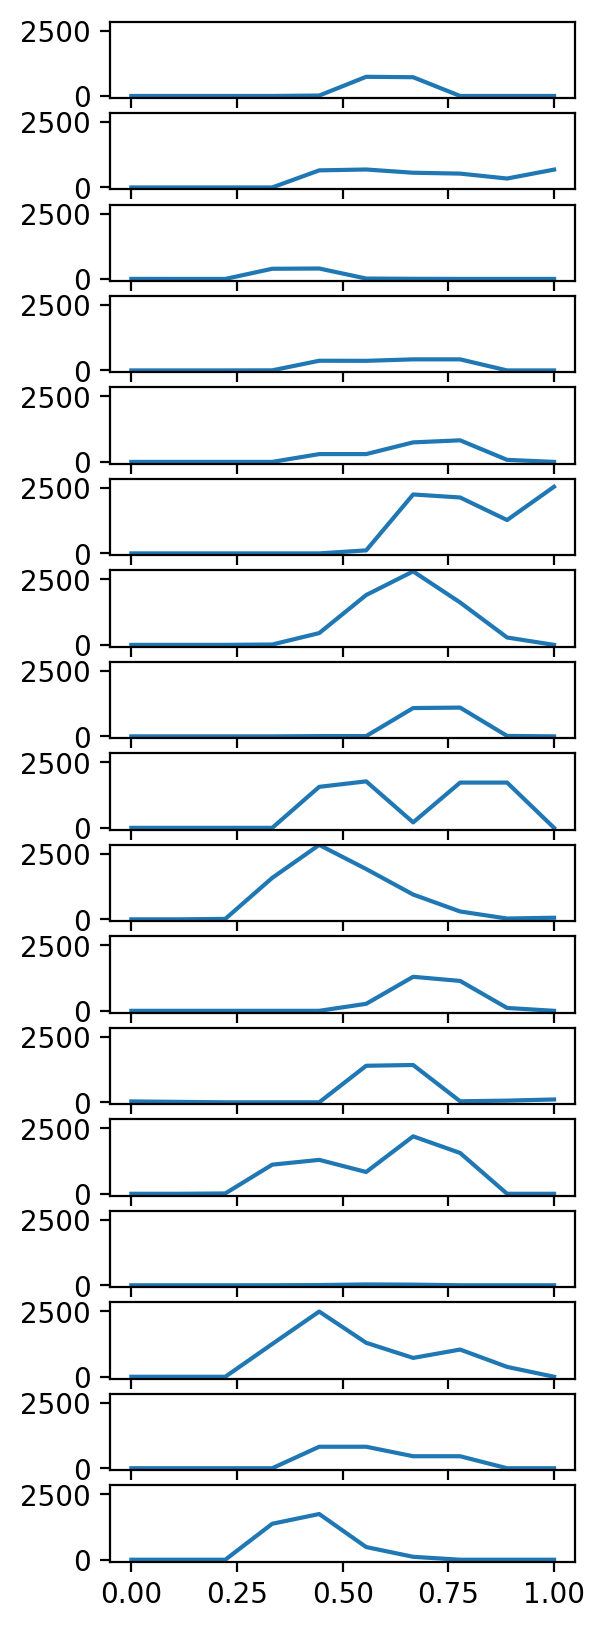

In [8]:
n_timestep = 10
timestep = np.linspace(0, 1, n_timestep)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    cum_steps_day = np.sum(step_events[idx_day] <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size-1)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    # print(np.sum(deriv_cum_steps_day))
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))


fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [9]:
class StepTransformer:
    def __init__(self):
        self.step_scaler = MinMaxScaler(feature_range=(1, 10))
        self.lambda_param = None

    def fit_transform(self, step_events):
        all_steps = np.concatenate(step_events)
        all_steps = logit(all_steps)
        all_steps = self.step_scaler.fit_transform(all_steps.reshape(-1, 1)).flatten()
        all_steps, self.lambda_param = stats.boxcox(all_steps)
        return self.transform(step_events)
    
    def _transform(self, step_events):
        X = np.asarray(step_events).reshape(-1, 1)
        return stats.boxcox(self.step_scaler.transform(logit(X)).flatten(), lmbda=self.lambda_param)
        
    def _inv_transform(self, transformed):
        return sigmoid(self.step_scaler.inverse_transform(inv_boxcox(transformed, self.lambda_param).reshape(-1, 1)).flatten())
    
    def transform(self, step_events):
        if isinstance(step_events, list):
            transformed = []
            for day in range(len(step_events)):
                transformed.append(self._transform(step_events[day]))
        else:
            transformed = self._transform(step_events)
        return transformed

    def inverse_transform(self, transformed):
        if not hasattr(self, "lambda_param"):
            raise ValueError("The transformer has not been fitted yet")
        if isinstance(transformed, list):
            inversed = []
            for day in range(len(transformed)):
                inversed.append(self._inv_transform(transformed[day]))
        else:
            inversed = self._inv_transform(transformed)
        return inversed

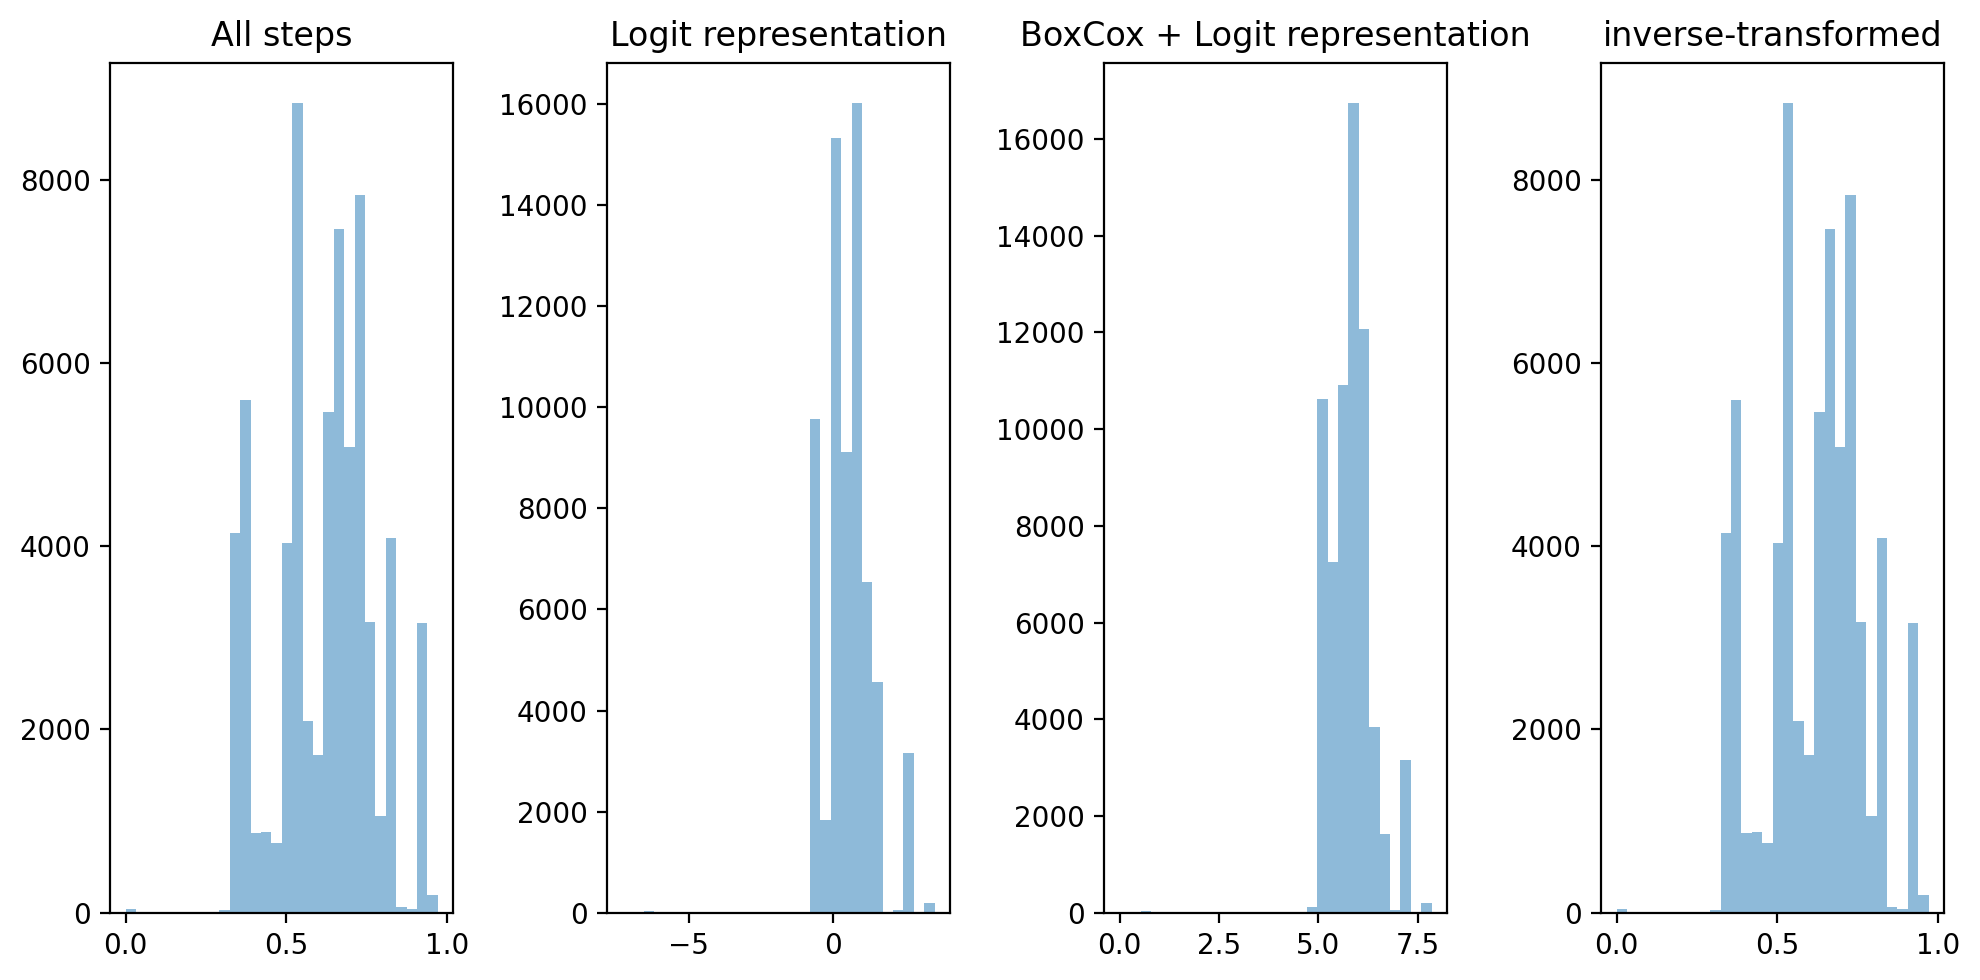

In [10]:
step_transformer = StepTransformer()
transformed_all_steps = step_transformer.fit_transform(step_events)
untransformed_all_steps = step_transformer.inverse_transform(transformed_all_steps)

fig, axes = plt.subplots(ncols=4, figsize=(10, 5))
fig.set_tight_layout(True)

ax = axes[0]
ax.set_title(f"All steps")
ax.hist(np.concatenate(step_events), bins=30, color="C0", alpha=0.5)

ax = axes[1]
ax.set_title("Logit representation")
ax.hist(logit(np.concatenate(step_events)), bins=30, color="C0", alpha=0.5)

ax = axes[2]
ax.set_title("BoxCox + Logit representation")
ax.hist(np.concatenate(transformed_all_steps), bins=30, color="C0", alpha=0.5)

ax = axes[3]
ax.set_title("inverse-transformed")
ax.hist(np.concatenate(untransformed_all_steps), bins=30, color="C0", alpha=0.5);

# Fit model alpha (lowest in hierachy)

In [11]:
class ParamTransformer:
    def __init__(self, step_events):
        self.max_n = max([len(step_events[day]) for day in range(n_days)])
    
    def transform(self, gmm):
        
        # Extract the parameters and transform them 
        transformed_means = gmm.means_.flatten()
        transformed_vars = np.log1p(gmm.covariances_).flatten()
        transformed_weights = logit(gmm.weights_.flatten())
        transformed_n = np.atleast_1d(np.log(X.size / self.max_n))
        
        # Store the transformed parameters
        if n_components == 1:
            features = [transformed_means, transformed_vars, transformed_n]

        else:
            features = [transformed_means, transformed_vars, transformed_weights, transformed_n]
        
        # Concatenate the transformed parameters
        return np.concatenate(features)
        
    def inverse_transform(self, features, n_components):
        
        # Extract the transformed parameters
        transformed_means = features[:n_components]
        transformed_vars = features[n_components:2*n_components]
        if n_components == 1:
            transformed_weights = np.empty(0)
        else:
            transformed_weights = features[2*n_components:-1]
        transformed_n = features[-1]
        
        # Inverse-transform the parameters
        means = transformed_means
        variances = np.expm1(transformed_vars)
        if n_components == 1:
            weights = np.ones(1)
        else:
            weights = sigmoid(transformed_weights) # Inverse of logit
            weights /= np.sum(weights)  # Normalise the weights
        
        n = int(round(np.exp(transformed_n) * self.max_n))
        
        # Store the inverse-transformed parameters
        return {
            "means": means, 
            "variances": variances, 
            "weights": weights, 
            "n": n}

In [12]:
# Define the range of number of components to try
n_model_types = 5
n_components_range = range(1, 1+n_model_types)

# Array to hold the BIC for each number of components
cmp_score = np.zeros((n_days, len(list(n_components_range))))

# Prepare the containers for the 2nd level GMM (GMM Beta) -------
all_features = []  
for n_components in n_components_range:
    if n_components == 1:
        # for each model: per day, logit(mean), log1p(var), n
        all_features.append(np.zeros((n_days, 3)))
    else:
        # for each model: per day, logit(means), log1p(var), logit(coeff)
        all_features.append(np.zeros((n_days, n_components*3+1)))

param_transformer = ParamTransformer(step_events)

# For evaluation purposes, we will also store generated steps
gen_deriv_cum_steps = np.zeros((n_model_types, n_days, n_timestep))

# Store the fitted models
all_alpha_gmm = np.zeros((n_model_types, n_days), dtype=object)

# ------------------------------------------------------------------

for day in tqdm(range(n_days)):
    
    # Get the (transformed) steps for the day
    X = transformed_all_steps[day].reshape(-1, 1)
    
    # Fit a Gaussian Mixture Model for each number of components
    for model, n_components in enumerate(n_components_range):
        
        # Fit the model
        gmm = GaussianMixture(n_components=n_components, random_state=123)
        gmm.fit(X)
        
        # Store the BIC score
        cmp_score[day, model] = gmm.bic(X)
        
        # Store the model
        all_alpha_gmm[model, day] = gmm
        
        # Store the (transformed) parameters (referred to as `features`)
        features = param_transformer.transform(gmm)
        all_features[model][day] = features

        # Generate the steps for the day with the fitted model        
        n = len(X.flatten())
        samples_alpha, _ = gmm.sample(n_samples=n) 
        
        # Inverse-transform the steps
        step_events_day = step_transformer.inverse_transform(samples_alpha).flatten()
        
        # Compute the cumulative steps and the derivative of the cumulative steps to get the activity
        cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
        deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
        gen_deriv_cum_steps[model, day] = deriv_cum_steps_day

  0%|          | 0/17 [00:00<?, ?it/s]

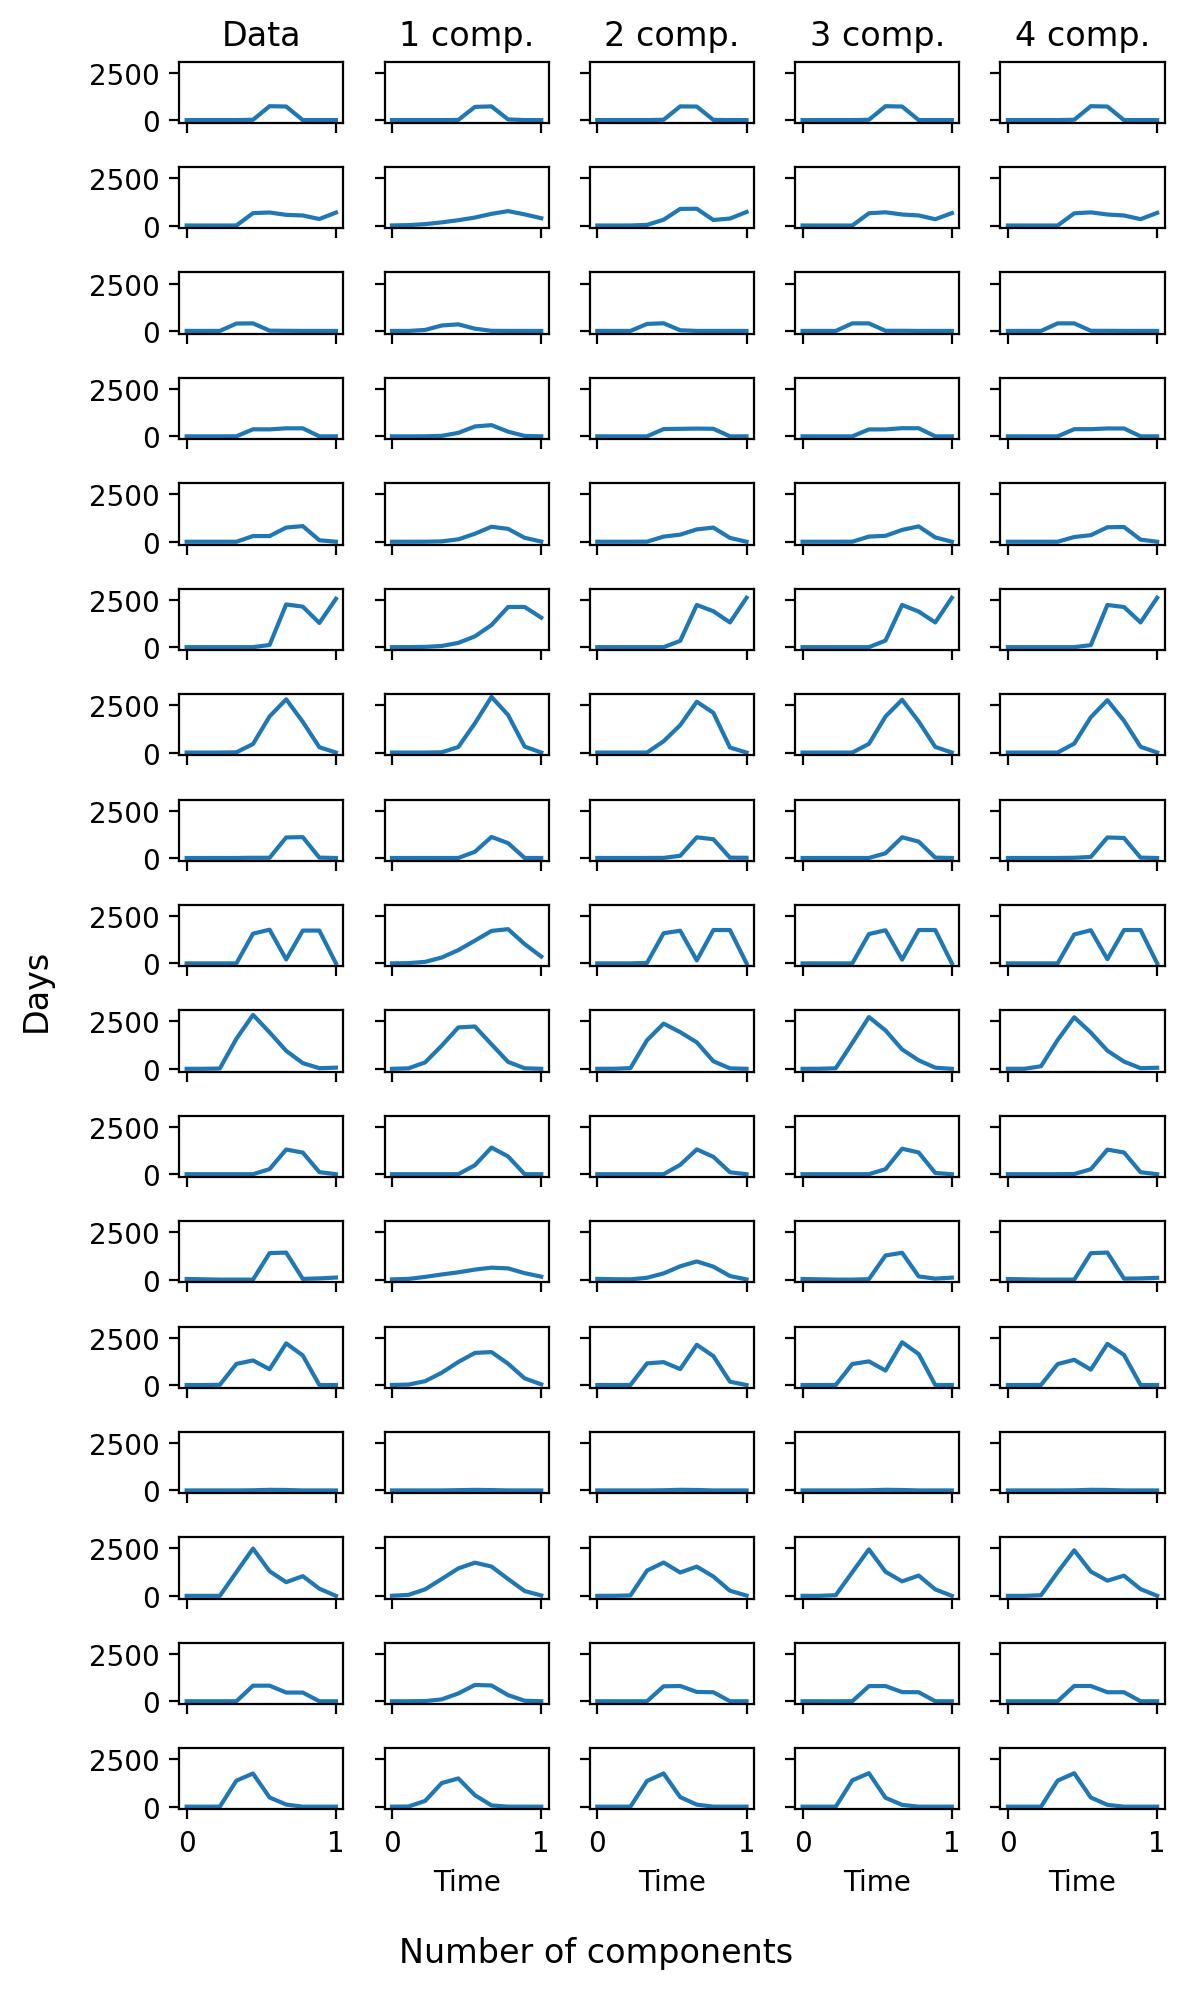

In [13]:
n_model_plot = min(n_model_types, 4)

fig, axes = plt.subplots(
    ncols=n_model_plot+1, 
    nrows=n_days,
    figsize=(6, 10), sharex=True, sharey=True)

fig.set_tight_layout(True)

for day in range(n_days):
    ax = axes[day, 0]
    ax.plot(timestep, deriv_cum_steps[day], color="C0")
    if day == 0:
        ax.set_title("Data")
    for model in range(n_model_plot):
        ax = axes[day, model+1]
        ax.plot(timestep, gen_deriv_cum_steps[model, day], color="C0")
        ax.grid(False)
        if day == 0:
            ax.set_title(f"{n_components_range[model]} comp.")
        elif day == n_days-1:
            ax.set_xlabel("Time")

fig.supxlabel("Number of components")
fig.supylabel("Days");

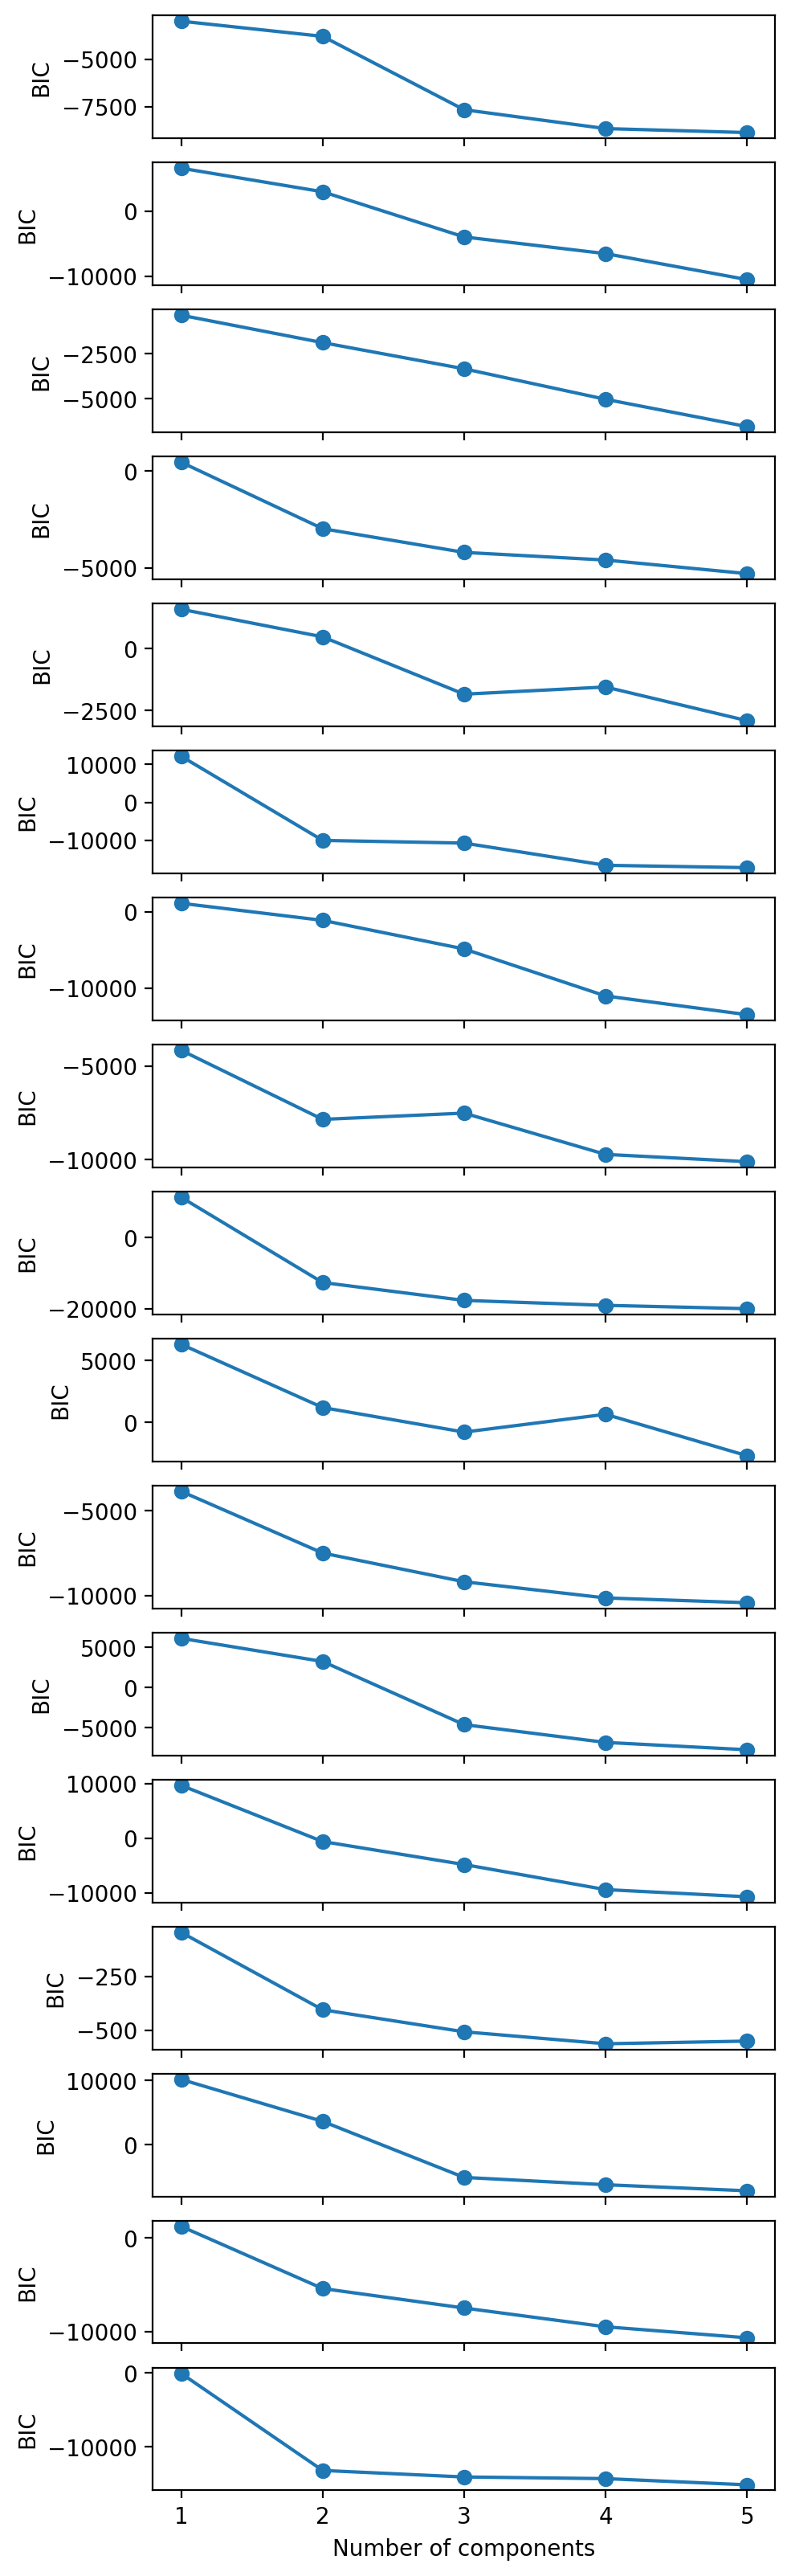

In [14]:
fig, axes = plt.subplots(nrows=n_days, figsize=(5, 20), sharex=True)
for day in range(n_days):
    ax = axes[day]
    ax.plot(n_components_range, cmp_score[day], marker='o')
    if day == n_days-1:(
        ax.set_xlabel('Number of components'))
    # have only integer ticks
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('BIC')

# Test the param transformer

In [15]:
number_of_components_alpha = 3
model = number_of_components_alpha - 1 # 0-indexed
X_train = all_features[model]
# Standardize the data
features_standardiser = StandardScaler()
X_train = features_standardiser.fit_transform(X_train)

models = all_alpha_gmm[model]

for day in range(n_days):
    gmm = models[day]
    means = gmm.means_.flatten()
    vars = gmm.covariances_.flatten()
    weights = gmm.weights_.flatten()
    n = len(step_events[day])
    
    print("means", means)
    print("vars", vars)
    print("weights", weights)
    print("n", n)
    
    X = X_train[day]
    un_standardised_feat = features_standardiser.inverse_transform(X.reshape(1, -1)).flatten()
    # Get back the GMM parameters by inverse-transforming the features
    params = param_transformer.inverse_transform(un_standardised_feat, number_of_components_alpha)
    
    print("means", params["means"])
    print("vars", params["variances"])
    print("weights", params["weights"])
    print("n", params["n"])
    print("-----")
    
    

means [5.83016748 5.70666839 5.36119917]
vars [2.04143293e-04 1.06811243e-05 1.80190977e-04]
weights [0.61638225 0.36177474 0.021843  ]
n 1465
means [5.83016748 5.70666839 5.36119917]
vars [2.04143293e-04 1.06811243e-05 1.80190977e-04]
weights [0.61638225 0.36177474 0.021843  ]
n 1465
-----
means [6.00904334 7.32277788 5.51633313]
vars [0.00473053 0.02734136 0.00021668]
weights [0.36118252 0.21915167 0.41966581]
n 3112
means [6.00904334 7.32277788 5.51633313]
vars [0.00473053 0.02734136 0.00021668]
weights [0.36118252 0.21915167 0.41966581]
n 3112
-----
means [5.16772502 0.20255369 5.77496668]
vars [8.38946688e-04 1.00000000e-06 1.00009349e-06]
weights [0.98638614 0.00123762 0.01237624]
n 808
means [5.16772502 0.20255369 5.77496668]
vars [8.38946688e-04 1.00000000e-06 1.00009349e-06]
weights [0.98638614 0.00123762 0.01237624]
n 808
-----
means [6.09019065 5.49318025 5.97453735]
vars [1.86137501e-03 1.01214873e-03 1.87964071e-05]
weights [0.30921363 0.4665404  0.22424596]
n 1584
means [

# Fit model beta (second in hierarchy)

In [17]:
number_of_components_alpha = 3
model = number_of_components_alpha - 1 # 0-indexed
X_train = all_features[model]
# Standardize the data
features_standardiser = StandardScaler()
X_train = features_standardiser.fit_transform(X_train)
print(X_train.shape)

n_components_range_beta = range(1, 18)

#TODO: try non-diagonal covariance
# 3. Fit a 3rd level GMM with the bic scores
all_beta_gmm = [GaussianMixture(n_components=n_components).fit(X_train) for n_components in n_components_range_beta]
all_beta_scores = [gmm.bic(X_train) for gmm in all_beta_gmm]

(17, 10)


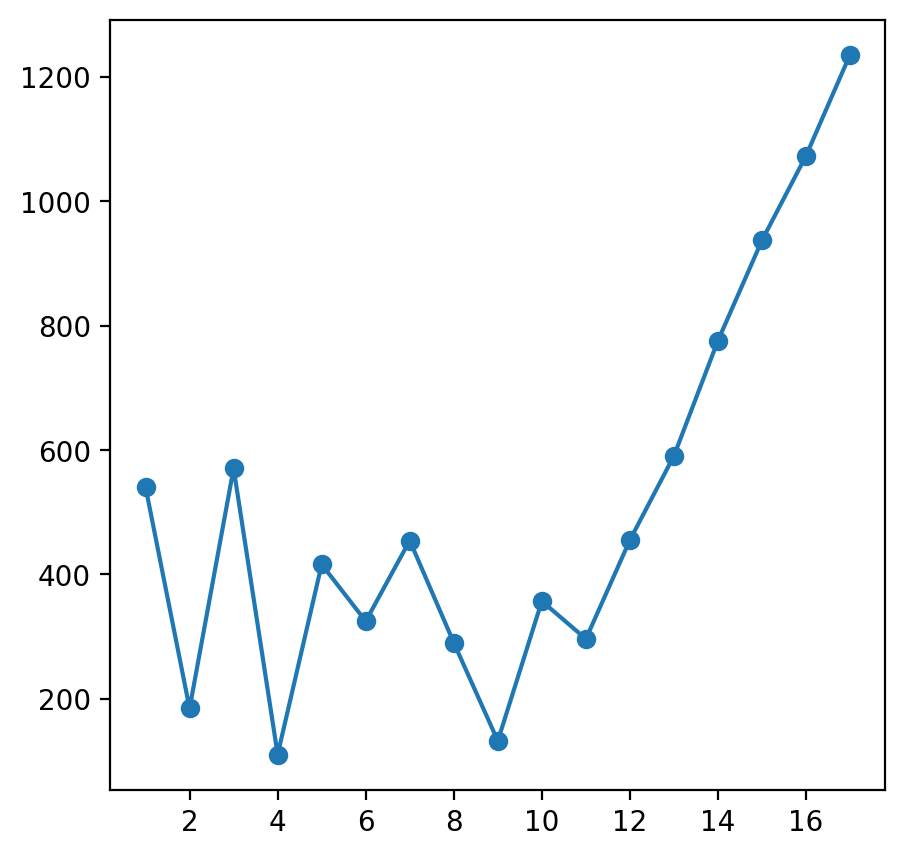

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(n_components_range_beta, all_beta_scores, marker='o')
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [19]:
# 4. Choose the best model
best_beta_idx = np.argmin(all_beta_scores)
best_beta_gmm = all_beta_gmm[best_beta_idx]

n_sample_beta = 100 # This will be number of days that will be generated

samples_beta, _  = best_beta_gmm.sample(n_samples=n_sample_beta)

In [20]:
np.random.seed(1234)

deriv_cum_steps = np.zeros((n_sample_beta, n_timestep))

for day in range(n_sample_beta):
    
    # Choose with type of model to use ---------------------------
    
    # Using the alpha-model, draw a model type for model-gamma according to the goodness of fit scores
    
    # Un-standardise the features
    X = samples_beta[day].reshape(1, -1)
    un_standardised_feat = features_standardiser.inverse_transform(X).flatten()
    # Get back the GMM parameters by inverse-transforming the features
    params = param_transformer.inverse_transform(un_standardised_feat, number_of_components_alpha)
    
    # Set up the gamma-model
    gmm = GaussianMixture(n_components=number_of_components_alpha)
    gmm.means_ = params["means"].reshape(-1, 1)
    gmm.covariances_ = params["variances"].reshape(-1, 1, 1)
    gmm.weights_ = params["weights"]
    
    # Get the number of samples to draw (= number of steps)
    n = params["n"]
    
    # Generate the (transformed) steps (ignore the 'covariance is not symmetric positive-semidefinite.' warning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    samples_alpha, _ = gmm.sample(n_samples=n) 
    warnings.filterwarnings("default", category=RuntimeWarning)
    
    # Inverse-transform the steps
    step_events_day = step_transformer.inverse_transform(samples_alpha).flatten()
    
    # Compute the cumulative steps and the derivative of the cumulative steps to get the activity
    cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
    deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
    deriv_cum_steps[day] = deriv_cum_steps_day 

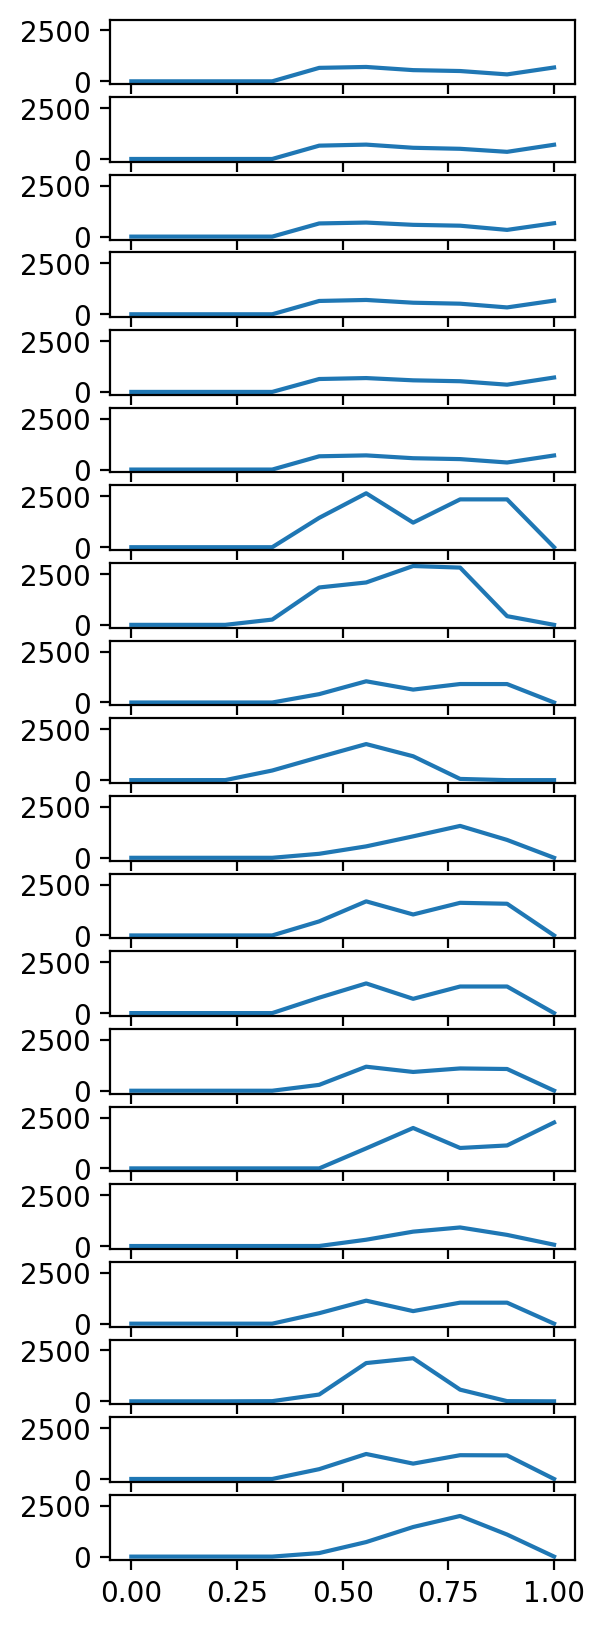

In [21]:
fig, axes = plt.subplots(min(deriv_cum_steps.shape[0], 20), figsize=(3, 10), sharex=True, sharey=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    # ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [22]:
def square_exponential_kernel(x, alpha, length):
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    sq_dist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(x**2, 1) - 2 * np.dot(x, x.T)
    return alpha**2 * np.exp(-0.5 * sq_dist / length**2)

In [25]:
mu = 750*np.cos(3 * (timestep - 2))
sigma = square_exponential_kernel(timestep, 50,  0.5)
rng = np.random.default_rng(1234)
push_effect = rng.multivariate_normal(mu, sigma, size=n_sample_beta)

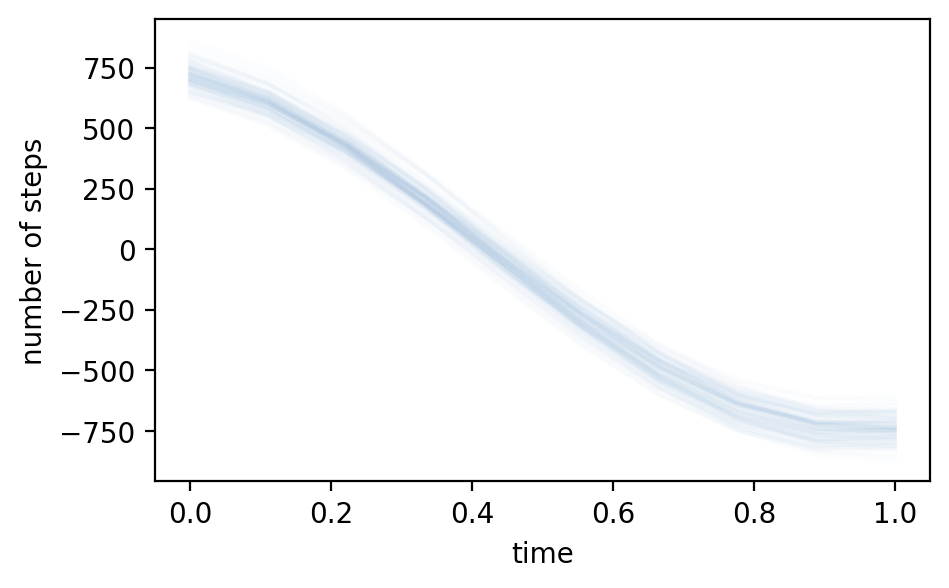

In [26]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(timestep, push_effect.T, color="C0", alpha=0.01)
ax.set_xlabel("time")
ax.set_ylabel("number of steps");

In [ ]:
activity = np.zeros((2,) + tuple(deriv_cum_steps.shape))
activity[0] = deriv_cum_steps
activity[1] = deriv_cum_steps + push_effect[:deriv_cum_steps.shape[0]]
activity[activity < 0] = 0

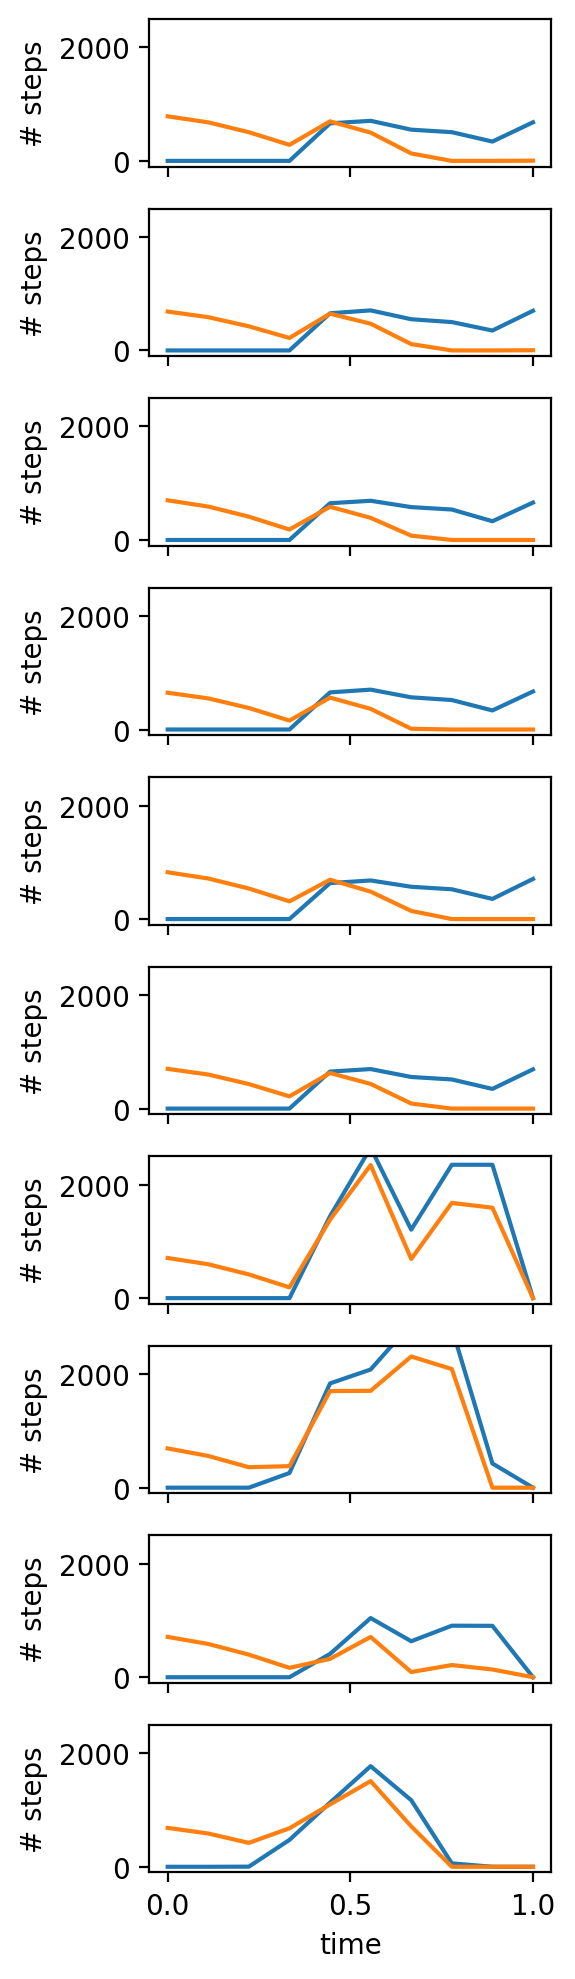

In [30]:
activity = np.zeros((2,) + tuple(deriv_cum_steps.shape))
activity[0] = deriv_cum_steps
activity[1] = deriv_cum_steps + push_effect[:deriv_cum_steps.shape[0]]
activity[activity < 0] = 0

# Plot the activity
n_samples = min(deriv_cum_steps.shape[0], 10) # Number of days
fig, axes = plt.subplots(n_samples, figsize=(3, 10), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(timestep, activity[0, i], color="C0")
    ax.plot(timestep, activity[1, i], color="C1")
    ax.set_ylim(np.min(activity) - 100, 2500)
    ax.grid(False)
    if i == len(axes) - 1:
        ax.set_xlabel("time")
    ax.set_ylabel("# steps")
fig.tight_layout()